## Data Import

In [272]:
import pandas as pd
from IPython.display import display

raw_csv = pd.read_csv(
    "data_digitization/wpd_datasets.csv",
    skiprows=2,
    names=[
        "Placebo: Days",
        "Placebo: Incidence",
        "mRNA: Days",
        "mRNA: Incidence"
    ]
)

display(raw_csv)


,Placebo: Days,Placebo: Incidence,mRNA: Days,mRNA: Incidence
0,1.115076,0.001827,4.049683,0.005868
1,2.957027,0.000534,6.016465,0.005228
2,4.705288,-0.000177,10.569710,0.020661
3,6.484779,0.004621,11.958433,0.019687
4,8.096114,0.006029,13.793824,0.035806
...,...,...,...,...
77,39.119577,0.361546,NaN,NaN
78,41.087061,0.379757,NaN,NaN
79,43.148233,0.441218,NaN,NaN
80,46.146303,0.461705,NaN,NaN


Isolate the two datasets. Add Day 0 to both graphs, where cumulative event rate is zero.

In [273]:
import numpy as np

placebo_data = pd.DataFrame(
    data={
        "Days": np.hstack((0, raw_csv["Placebo: Days"])),
        "Incidence": np.hstack((0, raw_csv["Placebo: Incidence"]))
    }
).dropna()

mrna_data = pd.DataFrame(
    data={
        "Days": np.hstack((0, raw_csv["mRNA: Days"])),
        "Incidence": np.hstack((0, raw_csv["mRNA: Incidence"]))
    }
).dropna()

placebo_data = placebo_data.sort_values("Days")
mrna_data = mrna_data.sort_values("Days")

Recreate the original plot as a sanity check:

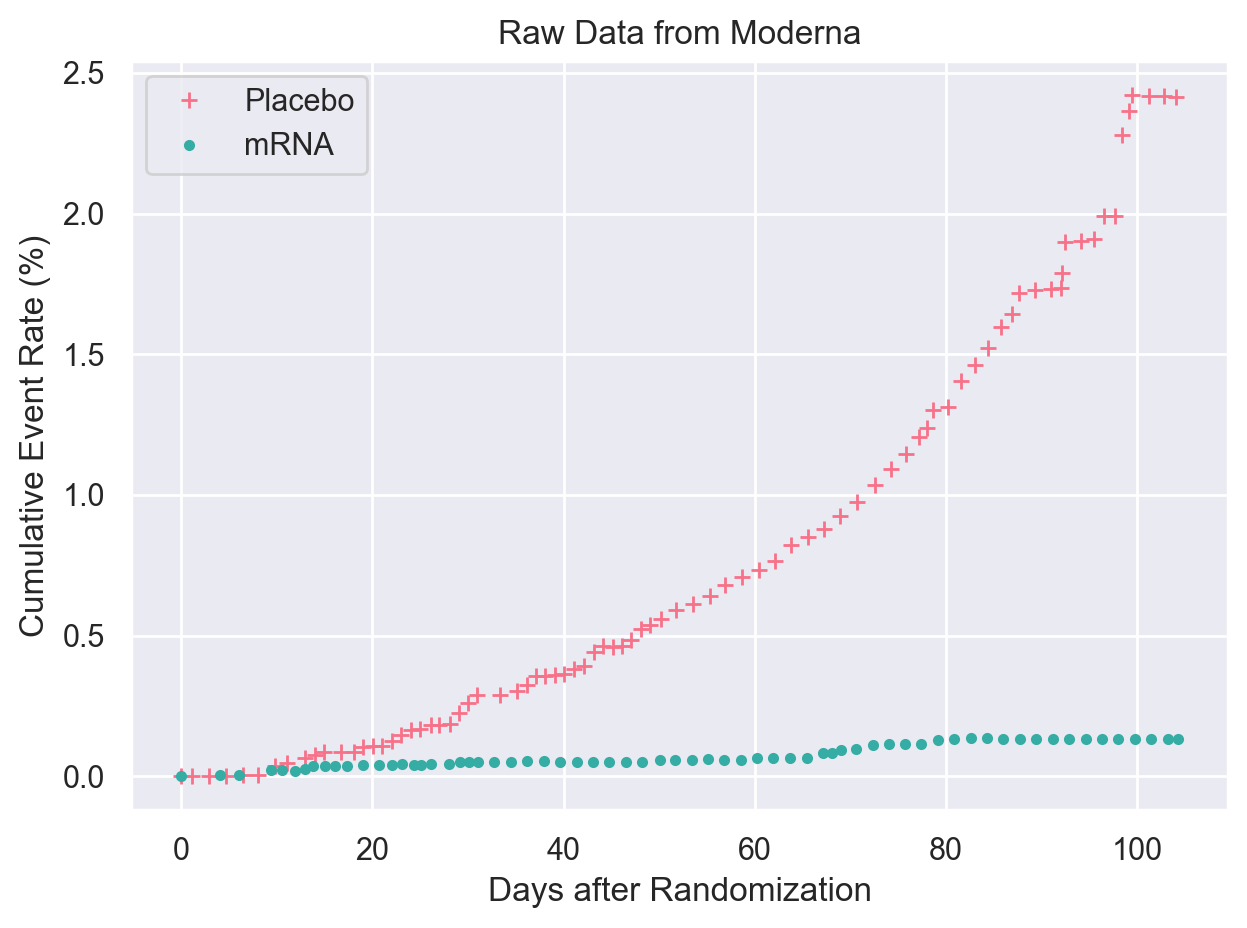

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette=sns.color_palette("husl", 2))

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
plt.plot(placebo_data["Days"], placebo_data["Incidence"], "+", label="Placebo")
plt.plot(mrna_data["Days"], mrna_data["Incidence"], ".", label="mRNA")
plt.xlabel(r"Days after Randomization")
plt.ylabel(r"Cumulative Event Rate (%)")
plt.title(r"Raw Data from Moderna")
plt.tight_layout()
plt.legend()
plt.savefig("datafig.png")
plt.show()


Create interpolators from the dataset for data comparison.

In [275]:
from scipy import interpolate

placebo_incidence = interpolate.interp1d(
    x=placebo_data["Days"],
    y=placebo_data["Incidence"],
)
mrna_incidence = interpolate.interp1d(
    x=mrna_data["Days"],
    y=mrna_data["Incidence"],
)
data_range = (
    1e-6,
    min(
        np.max(placebo_data["Days"]),
        np.max(mrna_data["Days"])
    )
)

Do a point analysis of the ratio of event rate as a function of day.

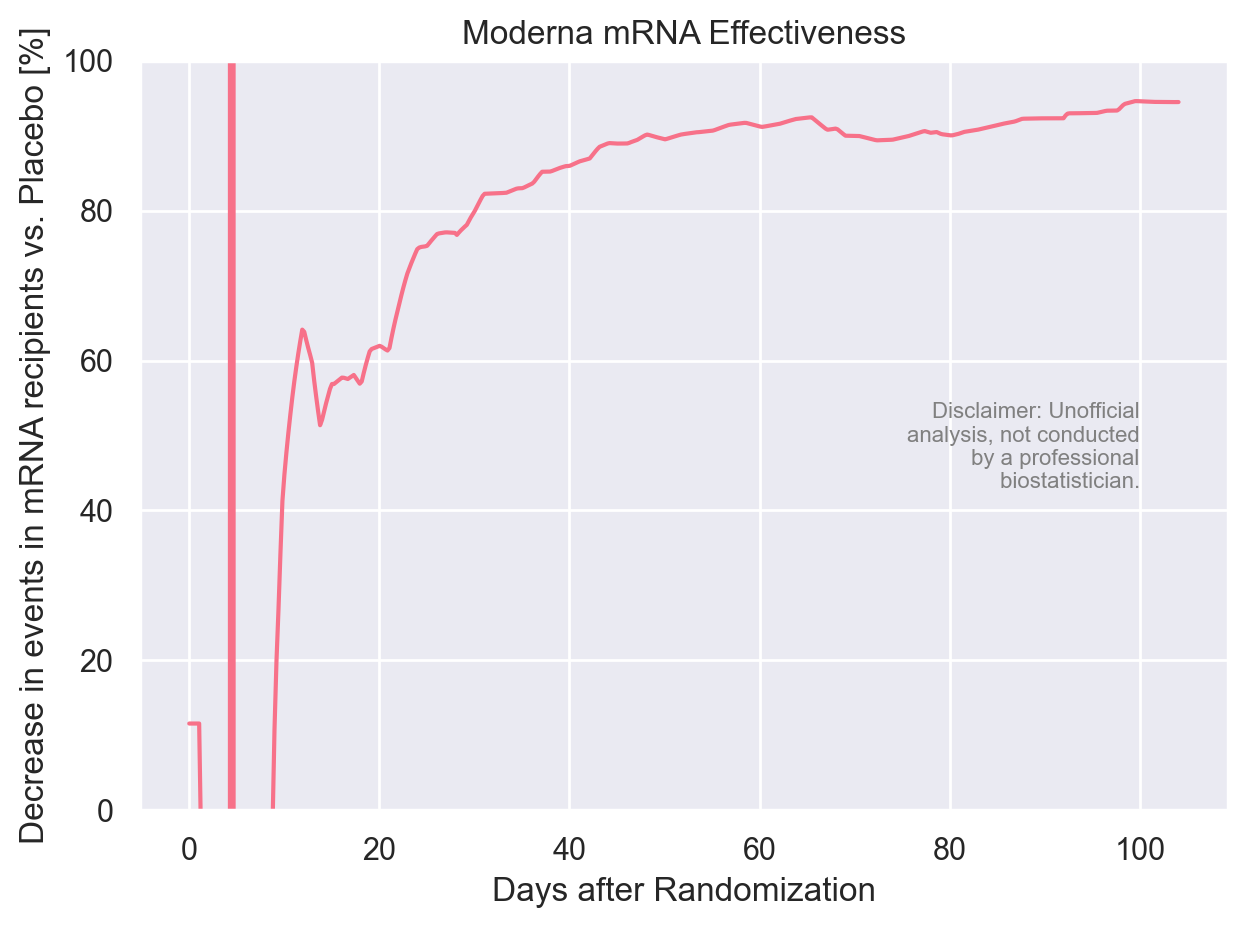

In [276]:
def add_disclaimer():
    plt.text(
        100, 50,
        """
        Disclaimer: Unofficial
        analysis, not conducted
        by a professional
        biostatistician.""",
        ha="right",
        va="center",
        color="gray",
        fontsize=8,
        wrap=True
    )

days = np.linspace(*data_range, 500)

effectiveness = 1 - mrna_incidence(days) / placebo_incidence(days)

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
plt.plot(days, effectiveness* 100)
plt.ylim(0, 100)
plt.xlabel(r"Days after Randomization")
plt.ylabel(r"Decrease in events in mRNA recipients vs. Placebo [%]")
plt.title(r"Moderna mRNA Effectiveness")
add_disclaimer()
plt.tight_layout()
plt.show()

Bootstrap this analysis to do uncertainty quantification:

In [277]:
from tqdm import tqdm

n_bootstraps = 5000

def add_error_from_digitization(array, stdev):
    return array + stdev * np.random.randn(*array.shape)

def get_weights(array):
    splits = np.random.rand(len(array) + 1) * len(array)  # "limit" bootstrapping
    splits[0] = 0
    splits[-1] = len(array)
    weights = np.diff(np.sort(splits))
    return weights

days = np.linspace(*data_range, 500)
effectiveness = np.empty(shape=(len(days), n_bootstraps))

placebo_days_original = np.array(placebo_data["Days"])
placebo_incidence_original = np.array(placebo_data["Incidence"])
mrna_days_original = np.array(mrna_data["Days"])
mrna_incidence_original = np.array(mrna_data["Incidence"])

for i in tqdm(range(n_bootstraps), desc="Bootstrapping", unit=" samples"):
    placebo_days = add_error_from_digitization(placebo_days_original, stdev = 110/200)
    placebo_incidence = add_error_from_digitization(placebo_incidence_original, stdev=2.5/200)
    sort_order = np.argsort(placebo_days)
    placebo_days = placebo_days[sort_order]
    placebo_incidence = placebo_incidence[sort_order]

    mrna_days = add_error_from_digitization(mrna_days_original, stdev = 110/200)
    mrna_incidence = add_error_from_digitization(mrna_incidence_original, stdev=2.5/200)
    sort_order = np.argsort(mrna_days)
    mrna_days = mrna_days[sort_order]
    mrna_incidence=mrna_incidence[sort_order]

    placebo_incidence_func = interpolate.UnivariateSpline(
        x=placebo_days,
        y=placebo_incidence,
        s=0.001,
        w=get_weights(placebo_incidence)
    )

    mrna_incidence_func = interpolate.UnivariateSpline(
        x=mrna_days,
        y=mrna_incidence,
        s=0.001,
        w=get_weights(mrna_incidence)
    )

    effectiveness[:, i] = 1 - mrna_incidence_func(days) / placebo_incidence_func(days)



Bootstrapping:   5%|▍         | 241/5000 [00:00<00:05, 802.02 samples/s]C:\Users\User\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
Bootstrapping:  71%|███████   | 3536/5000 [00:04<00:02, 663.06 samples/s]C:\Users\User\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:279: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
Bootstrapping: 100%|██████████| 5000/5000 [00:06<00:00, 748.17 sa

Analyze the bootstrapped data:

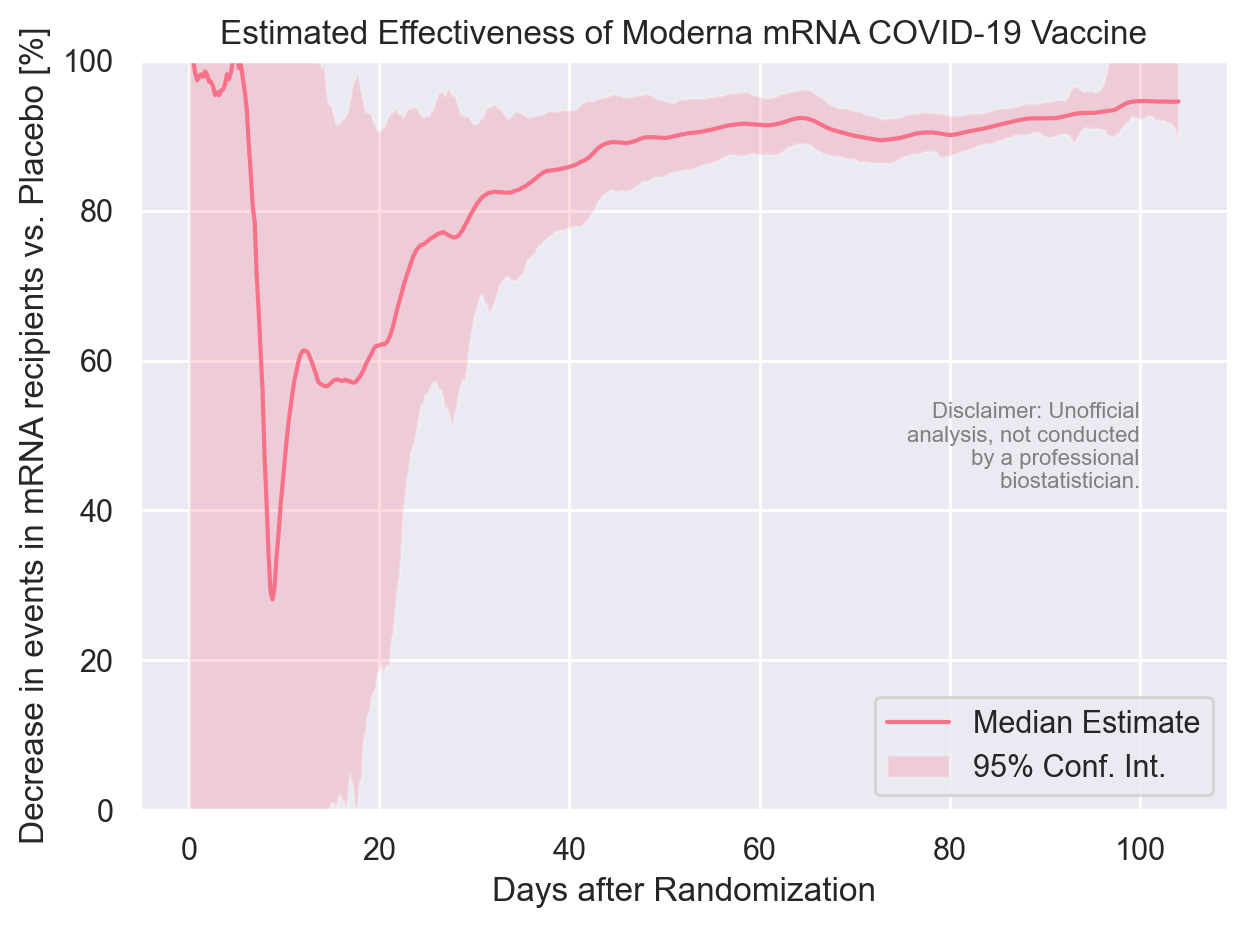

In [278]:
median_effectiveness = np.median(effectiveness,axis=1)
ci = 0.95

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
plt.plot(days, median_effectiveness * 100,
    label="Median Estimate"
         )
ci_effectiveness = np.nanquantile(
    effectiveness,
    q=[
        (1-ci)/2,
        1-(1-ci)/2
    ],
    axis=1,
)
plt.fill_between(
    days,
    ci_effectiveness[0,:] * 100,
    ci_effectiveness[1,:] * 100,
    alpha=0.25,
    label="95% Conf. Int."
)
plt.ylim(0, 100)
plt.xlabel(r"Days after Randomization")
plt.ylabel(r"Decrease in events in mRNA recipients vs. Placebo [%]")
plt.title(r"Estimated Effectiveness of Moderna mRNA COVID-19 Vaccine")
plt.legend(loc="lower right")
add_disclaimer()
plt.tight_layout()
plt.savefig("estimate.png")
plt.show()